In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from yellowbrick.regressor import ResidualsPlot, PredictionError

# Read in Pickle

In [2]:
# cleaned_KC = pd.read_pickle('./data/cleaned_KC.pkl')
# xtrain = pd.read_pickle('./data/xtrain_pickle.pkl')
# ytrain = pd.read_pickle('./data/ytrain_pickle.pkl')
# xtest  = pd.read_pickle('./data/xtest_pickle.pkl')
# ytest  = pd.read_pickle('./data/ytest_pickle.pkl')

In [3]:
xytrain= pd.read_pickle('./data/xytrain_pickle.pkl')
xytest = pd.read_pickle('./data/xytest_pickle.pkl')

X_train = xytrain.drop(columns=['price'])
y_train = xytrain['price']

X_test = xytest.drop(columns=['price'])
y_test = xytest['price']

# Check for Linear Relationship

### Calculate Pearson's R Value
Pearson's R represents a correlation coefficient. So a Pearson's R > .5  means there is a positive correlation between the feature. We can see that ```sqft_living``` show a positive correlation.

In [4]:
# How do we run Pearson's R when xtrain doesn't have price?
xytrain.corr()['price'].sort_values(ascending=False)

price             1.000000
sqft_living       0.608675
grade_9           0.358880
grade_10          0.302856
floors_2.0        0.245509
                    ...   
bathrooms_6.5          NaN
bathrooms_6.75         NaN
bathrooms_7.75         NaN
bathrooms_8.0          NaN
grade_13               NaN
Name: price, Length: 65, dtype: float64

# Check for Multicollinearity

### Calculate VIF

The variance inflation factor is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone.
It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. 
It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

In [5]:
# select only columns with datatype int64 or float 64
# numeric_cleaned_KC = xytrain.select_dtypes(include=['int64','float64']).drop(axis=1, columns=['price'])

# vif = pd.DataFrame()

# # For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
# vif["VIF Score"] = [variance_inflation_factor(numeric_cleaned_KC.values, i) for i in range(numeric_cleaned_KC.shape[1])]

# # label the scores with their related columns
# vif["features"] = numeric_cleaned_KC.columns

# vif.round(1)

If VIF > 5 there is an _indication_ that multicollinearity may be present; with VIF > 10 there is **certainly** multicollinearity among the variables.

Based on the first run of the VIF scores, ```Sqft_living``` and ```sqft_living15``` clearly have multi-collinearity, thus we will drop ```sqft_living15``` to reduce noise. 

In [6]:
# # drop sqft_living15
# numeric_cleaned_KC = numeric_cleaned_KC.drop(axis=1, columns=['sqft_living15'])

# vif = pd.DataFrame()

# # For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
# vif["VIF Score"] = [variance_inflation_factor(numeric_cleaned_KC.values, i) for i in range(numeric_cleaned_KC.shape[1])]

# # label the scores with their related columns
# vif["features"] = numeric_cleaned_KC.columns

# vif.round(1)

# Linear Regression
Because our first two assumptions (Linear Relationship & No Multicollinearity) were met, we decided to run a basic Linear Regression.

### Calculate Regression Line of Price vs Sqft_living

In [7]:
# Transforms a dataframe into a np.array
X = xytrain['sqft_living'].values.reshape(-1,1)
y = xytrain['price'].values.reshape(-1,1)

# Create a Linear Regression object and fit a line using X and y
reg = LinearRegression()
reg.fit(X, y)

# using that line, make predictions for y using X
predictions = reg.predict(X)

### Plot Regression against Scatterplot

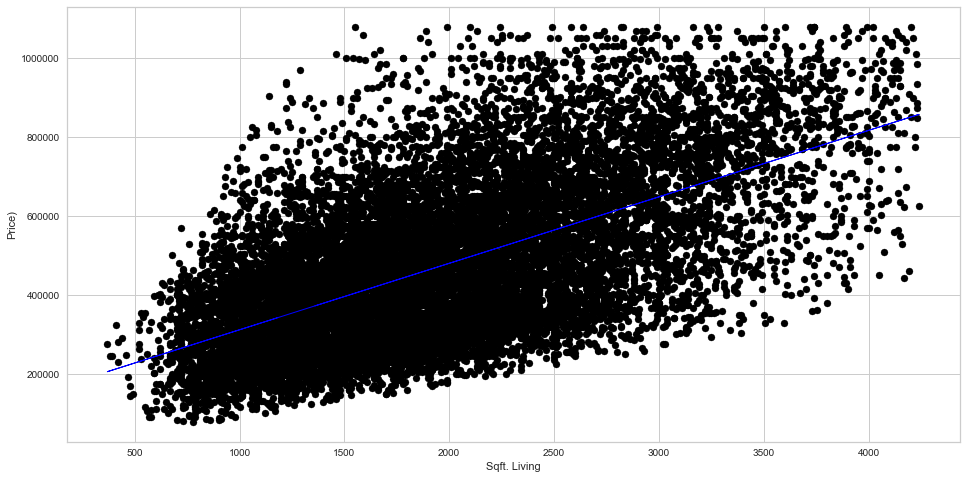

In [8]:
# Make a 16x8 figure that has...
plt.figure(figsize=(16, 8))

# ...a scatter plot of sqft_living vs price...
plt.scatter( X, y, c='black')

# ...plot the regression line...
plt.plot( X, predictions, c='blue', linewidth=1)

# ...set the labels and show
plt.xlabel("Sqft. Living")
plt.ylabel("Price)")
plt.show()

### Calculate OLS Regression Results

In [9]:
X = xytrain['sqft_living'] # Set X to sqft_living values
y = xytrain['price'] # Set y to price values
X2 = sm.add_constant(X) # add intercept column
est = sm.OLS(y, X2).fit() # Pass in X2 and y into Ordinary Least Square model
print(est.summary()) # Print out the report summary 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     9277.
Date:                Thu, 03 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:22:24   Log-Likelihood:            -2.1137e+05
No. Observations:               15765   AIC:                         4.227e+05
Df Residuals:                   15763   BIC:                         4.228e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.432e+05   3641.875     39.327      

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### <span style="color:blue">Our Linear Regression R-Squared result:</span><span style="color:red"> .39</span>

# Multiple Linear Regression w/ Categorical Variables

### Calculate OLS

In [10]:
# Simply adding a y-intercept column.
X2 = sm.add_constant(X_train)

# Run an Ordinary Least Squares model using the array of y values, and the dataframe of x_train values and fit a line to it. 
est = sm.OLS(y_train, X2).fit()

# Checking Assumptions

### Residuals Plots - Checking Errors are normal
Before we compare which model best predicts our target, we want to ensure that our predicted errors are normally distributed. 

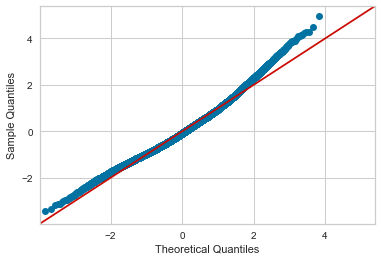

In [11]:
residuals = est.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

Based on our QQ plot, we can conclude that our errors are **not** normally distributed.

### Homoscedasticity
We also want to test for Homescedasticity - meaning the variance within the residuals should be constant

#### ScatterPlot the predicted values against the residuals

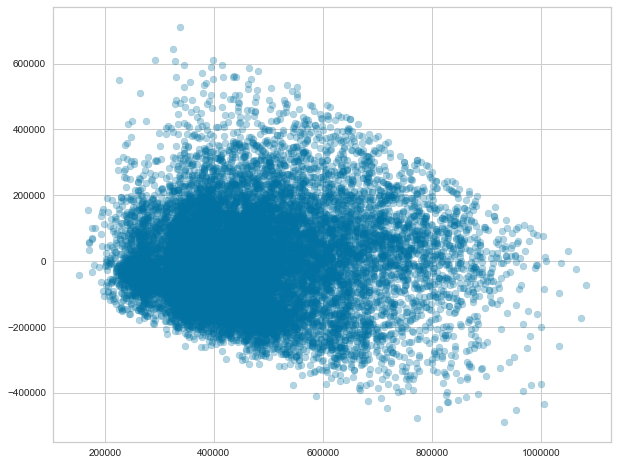

In [12]:
pred_val = est.fittedvalues.copy()
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pred_val, residuals, alpha = 0.3)

#### Yellow Brick Residuals Plot

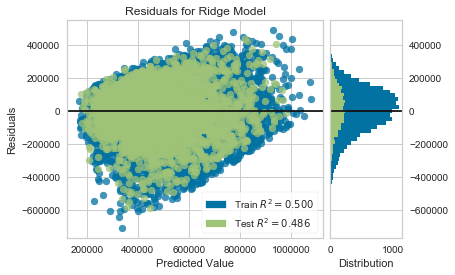

In [13]:
model = Ridge()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

Based on the results from our scatterplot of residuals, we can conclude that our residuals are **not** normally distributed.

### Kurtosis, Skewness & Shapiro-Wilk tests

In [14]:
price_column = xytrain.price

# Kurtosis test
print( 'excess kurtosis of normal distribution (should be 0): {}'.format( stats.kurtosis(price_column) ))

# Skewness test
print( 'skewness of normal distribution (should be 0): {}'.format( stats.skew(price_column) ))

# We don't know what this does, so we shouldn't use it. 
# Shapiro-Wilk Test
# stat, p = stats.shapiro(price_column)
# alpha = 0.05
# if p > alpha:
#     print('Sample looks Gaussian (fail to reject H0): Statistics=%.3f, p=%.3f' % (stat, p))
# else:
#     print('Sample does not look Gaussian (reject H0): Statistics=%.3f, p=%.3f' % (stat, p))

excess kurtosis of normal distribution (should be 0): -0.12387756391923643
skewness of normal distribution (should be 0): 0.7058018908810839


## Results of Assumptions Tests

Based on the results of our assumptions tests, we can determine that our residuals of the price feature is not normally distributed and will require a transformation to reflect a normal distribution. Proceed to the log_modeling notebook to continue the narrative.

## OR

Continue down this notebook to see how Regression Models are affected by a non-transformed price feature

# Regression Models

## Linear Regression

In [15]:
# Creates a Linear Regression object
lin_reg = LinearRegression()

# Train the Regression object to fit a line with train data
lin_reg.fit(X_train, y_train)

# using that line, predict y values against x_test values.
y_pred = lin_reg.predict(X_test)

# Use sklearn.metrics.r2_score to determine r-squared based on y_test values and y_pred values.
r_squared = r2_score(y_test, y_pred).round(3)
r_squared

0.485

## Ridge Regression

In [16]:
ridge = Ridge()
alpha_values = [.001,.01,.1,1,10,100]
parameters = {'alpha': alpha_values}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv = 5)

ridge_regressor.fit(X_train,y_train)

ridge_squared = ridge_regressor.best_score_.round(3)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 1}
0.4960147527635645


## Lasso Regression

In [17]:
lasso = Lasso(max_iter=10000)
alpha_values = [.001,.01,.1,1,10,100]
parameters = {'alpha': alpha_values}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv = 5)

lasso_regressor.fit(X_train,y_train)

lasso_squared = lasso_regressor.best_score_.round(3)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78229651932919.03, tolerance: 52118993024.19792
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65079786015255.16, tolerance: 51762272114.915565
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50796084020240.78, tolerance: 51961329834.18703
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63927257330165.

{'alpha': 100}
0.4961559413723631


# Review final metrics

In [18]:
print("MSE: {}".format(mean_squared_error(y_test, y_pred).round(3)))
print("Linear Regression: {}".format(r_squared))
print("Ridge Regression: {}".format(ridge_squared))
print("Lasso Regression: {}".format(lasso_squared))

MSE: 19469685279.206
Linear Regression: 0.485
Ridge Regression: 0.496
Lasso Regression: 0.496


While these r-squared values don't look too bad, when we take MSE into account, we can conclude that there is more work that needs to be done.